# Import Lib

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import SimpleRNN, Input, Dense, Dropout, LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from tensorflow.keras.models import Sequential

from keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
from tensorflow import keras
import plotly.graph_objects as go

from google.colab import drive
import os

# PATH

In [2]:
drive.mount('/content/drive/')
os.chdir('/content/drive/My Drive/')

project_path = "Report_DBA/"
source_path = project_path + "source/"
data_path = project_path + "data/BTC-USD.csv"

Mounted at /content/drive/


In [3]:
df = pd.read_csv(data_path)
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
1822,04/22/2023,27265.89453,27872.14258,27169.57031,27817.50000,27817.50000,1.312573e+10
1823,04/23/2023,27816.14453,27820.24414,27400.31445,27591.38477,27591.38477,1.278545e+10
1824,04/24/2023,27591.73047,27979.98242,27070.84961,27525.33984,27525.33984,1.770329e+10
1825,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1826,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Preprocessing

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1827 entries, 0 to 1826
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1825 non-null   object 
 1   Open       1825 non-null   float64
 2   High       1825 non-null   float64
 3   Low        1825 non-null   float64
 4   Close      1825 non-null   float64
 5   Adj Close  1825 non-null   float64
 6   Volume     1825 non-null   float64
dtypes: float64(6), object(1)
memory usage: 100.0+ KB


Nhận thấy dữ liệu có 1827 dòng nhưng có 2 dòng bị thiếu ==> Vậy nên cần xử lý các dòng đó

In [5]:
# do 2 dòng này nằm cuối dữ liệu nên không cần tìm giá trị thay thế mà trực tiếp loại bỏ
df.dropna(inplace=True)

# Plot

In [6]:
fig = go.Figure(data=[go.Candlestick(x=df['Date'],
                open=df['Open'], high=df['High'],
                low=df['Low'], close=df['Close'])
                     ])

fig.update_layout(xaxis_rangeslider_visible=False)
fig.show()

# Train Test vs Validation Split

In [7]:
n_observations = df.shape[0]
features = ["Open", "High", "Low", "Volume", "Adj Close"]

df = df[ features]
train = df[:int(n_observations*0.7)]
test = df[int(n_observations*0.7): int(n_observations*0.9)]
val = df[int(n_observations*0.9):]

# Helper Functions

In [8]:
def to_supervised(data, lookback = 3):
    n = data.shape[0]
    X, y = list(), list()
    for i in range(n - lookback):
        X.append(data[i: i + lookback])
        y.append(data[i+lookback, -1])
    return np.array(X), np.array(y)

# Main Run

## Prepare data

In [9]:
scaler = MinMaxScaler().fit(train)
y_scaler = MinMaxScaler().fit(train.values[:, -1].reshape(-1, 1))
train_scaled = scaler.transform(train)
test_scaled = scaler.transform(test)
val_scaled = scaler.transform(val)

train_X, train_y= to_supervised(train_scaled, 3)
test_X, test_y = to_supervised(test_scaled, 3)
val_X, val_y = to_supervised(val_scaled, 3)

## RNN Model

In [10]:
rnn_model = Sequential()

rnn_model.add(Input(shape=train_X.shape[1:]))
rnn_model.add(SimpleRNN(128))

# Add a Dense layer using for ouput
rnn_model.add(Dense(1))

rnn_model.compile(loss='mse',
                  optimizer='adam',
                   metrics=[
                       'mae', tf.keras.metrics.RootMeanSquaredError() , 'mape'
                   ])
rnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 128)               17152     
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 17,281
Trainable params: 17,281
Non-trainable params: 0
_________________________________________________________________


## Train data

In [11]:
history = rnn_model.fit(train_X, train_y, 
          epochs = 300, 
          batch_size=32, 
          validation_data=(val_X, val_y))

Epoch 1/300
40/40 [==============================] - 2s 12ms/step - loss: 0.0189 - mae: 0.0720 - root_mean_squared_error: 0.1374 - mape: 2324.0916 - val_loss: 2.8661e-04 - val_mae: 0.0119 - val_root_mean_squared_error: 0.0169 - val_mape: 3.9912
Epoch 2/300
40/40 [==============================] - 0s 4ms/step - loss: 8.4700e-04 - mae: 0.0171 - root_mean_squared_error: 0.0291 - mape: 2829.5166 - val_loss: 6.7495e-04 - val_mae: 0.0223 - val_root_mean_squared_error: 0.0260 - val_mape: 7.7215
Epoch 3/300
40/40 [==============================] - 0s 4ms/step - loss: 6.2573e-04 - mae: 0.0146 - root_mean_squared_error: 0.0250 - mape: 2723.2837 - val_loss: 7.0279e-04 - val_mae: 0.0229 - val_root_mean_squared_error: 0.0265 - val_mape: 7.9054
Epoch 4/300
40/40 [==============================] - 0s 5ms/step - loss: 6.7132e-04 - mae: 0.0150 - root_mean_squared_error: 0.0259 - mape: 1542.1584 - val_loss: 0.0011 - val_mae: 0.0299 - val_root_mean_squared_error: 0.0334 - val_mape: 10.3411
Epoch 5/300
40

## Test data

12/12 [==============================] - 0s 2ms/step


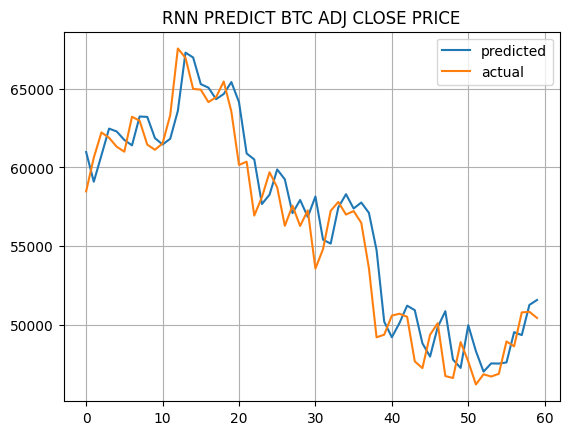

In [12]:
# number of days used for flotting
days = 60

pred = rnn_model.predict(test_X)

# inverse data to origin values
y_predicted = y_scaler.inverse_transform(np.array(pred).reshape(-1, 1)).reshape(-1, )
y_true = y_scaler.inverse_transform(np.array(test_y).reshape(-1, 1)).reshape(-1, )

# plot
plt.grid(True)
plt.plot(y_predicted[:days], label="predicted")
plt.plot(y_true[:days], label="actual")
plt.title("RNN PREDICT BTC ADJ CLOSE PRICE")
plt.legend()
plt.show()

# Evaluate


In [13]:
mae = mean_absolute_error(y_true, y_predicted)
rmse = np.sqrt(mean_squared_error(y_true, y_predicted))
mape = mean_absolute_percentage_error(y_true, y_predicted)
print(f"MAE: {mae}")
print(f"RMSE: {rmse}")
print(f"mape: {mape}")

MAE: 1054.0738297168507
RMSE: 1450.7031197790427
mape: 0.031136817352687498


# Tuning Hyperparameters

In [14]:
!pip install keras-tuner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 13.4 MB/s eta 0:00:00


In [15]:
from kerastuner import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters

<ipython-input-15-2bbfbe7dae29>:1: DeprecationWarning:

`import kerastuner` is deprecated, please use `import keras_tuner`.



In [16]:
def build_model(hp):
    model = Sequential()
    model.add(Input(shape=train_X.shape[1:]))
    
    model.add(SimpleRNN(units=hp.Int(f'rnn_units', min_value=32, max_value=1024, step=32)))
    
    num_dense = hp.Int("num_dense", min_value=0, max_value=5, step=1)
    # Tune the number of Dense Layers
    for i in range(num_dense):
        model.add(
            Dense(
                units=hp.Int(f'units_{i}', min_value=32, max_value=1024, step=32)))
    
    model.add(Dense(1))
    
    # lr = hp.Float("lr", min_value=1e-5, max_value=1e-2, sampling='log')
        
    model.compile(loss='mse',
                  optimizer='adam',
                   metrics=[
                       'mae', tf.keras.metrics.RootMeanSquaredError() , 'mape'
                   ])
    return model

In [30]:
tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=3,
    directory='TUNING',
    project_name='RNN')

In [31]:
from keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=8)
tuner.search(train_X, train_y,
             epochs=100,
             validation_data=(val_X, val_y),
            callbacks=[early_stop])

best_model = tuner.get_best_models(num_models=1)[0]

Trial 10 Complete [00h 02m 09s]
val_loss: 0.00011804207557967554

Best val_loss So Far: 0.00010873843954565625
Total elapsed time: 00h 15m 01s


In [32]:
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 224)               51520     
                                                                 
 dense (Dense)               (None, 224)               50400     
                                                                 
 dense_1 (Dense)             (None, 416)               93600     
                                                                 
 dense_2 (Dense)             (None, 288)               120096    
                                                                 
 dense_3 (Dense)             (None, 704)               203456    
                                                                 
 dense_4 (Dense)             (None, 1)                 705       
                                                                 
Total params: 519,777
Trainable params: 519,777
Non-trai

In [33]:
tuner.results_summary()

Results summary
Results in TUNING/RNN
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 06 summary
Hyperparameters:
rnn_units: 224
num_dense: 4
units_0: 224
units_1: 416
units_2: 288
units_3: 704
units_4: 832
Score: 0.00010873843954565625

Trial 02 summary
Hyperparameters:
rnn_units: 32
num_dense: 4
units_0: 480
units_1: 992
units_2: 736
units_3: 800
units_4: 480
Score: 0.00010981808736687526

Trial 07 summary
Hyperparameters:
rnn_units: 608
num_dense: 2
units_0: 224
units_1: 896
units_2: 640
units_3: 896
units_4: 896
Score: 0.00011281858072228108

Trial 08 summary
Hyperparameters:
rnn_units: 608
num_dense: 2
units_0: 256
units_1: 608
units_2: 608
units_3: 352
units_4: 480
Score: 0.00011672699474729598

Trial 09 summary
Hyperparameters:
rnn_units: 704
num_dense: 0
units_0: 224
units_1: 288
units_2: 832
units_3: 32
units_4: 544
Score: 0.00011804207557967554

Trial 05 summary
Hyperparameters:
rnn_units: 832
num_dense: 1
units_0: 640
units_1: 192
units_2: 32
units_

## Build model with best hyperparameters 

In [34]:
# define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

best_hps = tuner.get_best_hyperparameters(5)
model = build_model(best_hps[0])
model.fit(train_X, train_y, 
          epochs = 100,
          batch_size = 32,
         validation_data=(val_X, val_y))

Epoch 1/100
40/40 [==============================] - 2s 17ms/step - loss: 0.1541 - mae: 0.1566 - root_mean_squared_error: 0.3926 - mape: 28190.3828 - val_loss: 4.1017e-04 - val_mae: 0.0169 - val_root_mean_squared_error: 0.0203 - val_mape: 5.7167
Epoch 2/100
40/40 [==============================] - 0s 10ms/step - loss: 0.0011 - mae: 0.0200 - root_mean_squared_error: 0.0332 - mape: 7227.2520 - val_loss: 1.5542e-04 - val_mae: 0.0080 - val_root_mean_squared_error: 0.0125 - val_mape: 2.7187
Epoch 3/100
40/40 [==============================] - 1s 16ms/step - loss: 3.3030e-04 - mae: 0.0100 - root_mean_squared_error: 0.0182 - mape: 2001.5804 - val_loss: 3.2684e-04 - val_mae: 0.0154 - val_root_mean_squared_error: 0.0181 - val_mape: 5.2964
Epoch 4/100
40/40 [==============================] - 1s 17ms/step - loss: 3.1606e-04 - mae: 0.0099 - root_mean_squared_error: 0.0178 - mape: 1206.8029 - val_loss: 1.1741e-04 - val_mae: 0.0070 - val_root_mean_squared_error: 0.0108 - val_mape: 2.3959
Epoch 5/100

## tesst

12/12 [==============================] - 0s 3ms/step


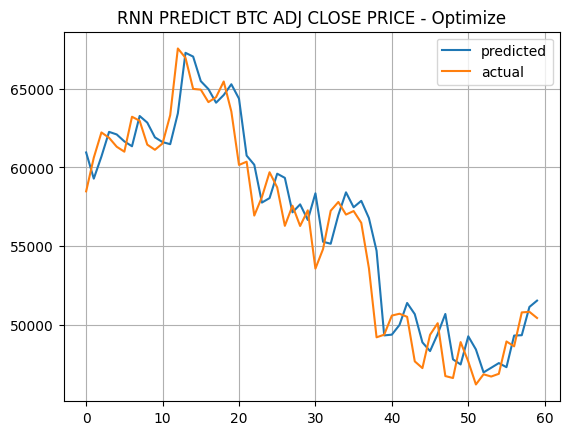

In [35]:
days = 60
pred = model.predict(test_X)
y_predicted = y_scaler.inverse_transform(np.array(pred).reshape(-1, 1)).reshape(-1, )
y_true = y_scaler.inverse_transform(np.array(test_y).reshape(-1, 1)).reshape(-1, )
plt.grid(True)
plt.plot(y_predicted[:days], label="predicted")
plt.plot(y_true[:days], label="actual")
plt.title("RNN PREDICT BTC ADJ CLOSE PRICE - Optimize")
plt.legend()
plt.show()

## Evaluate

In [36]:
mae = mean_absolute_error(y_true, y_predicted)
rmse = np.sqrt(mean_squared_error(y_true, y_predicted))
mape = mean_absolute_percentage_error(y_true, y_predicted)
print(f"MAE: {mae}")
print(f"RMSE: {rmse}")
print(f"mape: {mape}")

MAE: 1013.6007256716157
RMSE: 1411.4735960237654
mape: 0.02999865892902855
